Notebook setup

In [1]:
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

# Make plots a bit nicer
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8, 5)

# Ensure reports folder exists
os.makedirs("../reports", exist_ok=True)

print("Setup complete - ready for drift monitoring.")


Setup complete - ready for drift monitoring.


Load training data

In [3]:
# Load training / reference data (HR dataset)
train_df = pd.read_csv('../06_ml/HR-Employee-Attrition.csv')
# Quick check
train_df.head()

# Convert Attrition Yes/No to 1/0 for stats
train_df["Attrition_Flag"] = (train_df["Attrition"] == "Yes").astype(int)

print("Training attrition rate:", train_df["Attrition_Flag"].mean())


Training attrition rate: 0.16122448979591836


Load recent batch predictions from PostgreSQL

In [4]:
# Connect to PostgreSQL and load batch predictions
conn = psycopg2.connect(
    dbname="intern_db",
    user="postgres",       
    password="kesia",  
    host="localhost",
    port="5432"
)

batch_df = pd.read_sql("SELECT * FROM hr_batch_predictions;", conn)
conn.close()

batch_df.head()


C:\Users\97156\AppData\Local\Temp\ipykernel_19092\1383542453.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  batch_df = pd.read_sql("SELECT * FROM hr_batch_predictions;", conn)


,employee_number,prediction,probability,batch_timestamp
0,1,0,0.0,2025-11-17 14:56:00.725017
1,2,0,0.0,2025-11-17 14:56:00.725017
2,4,0,0.0,2025-11-17 14:56:00.725017
3,5,0,0.0,2025-11-17 14:56:00.725017
4,7,0,0.0,2025-11-17 14:56:00.725017


Join HR features + batch predictions

In [5]:
# Merge HR features with batch predictions on employee number
merged_df = train_df.merge(
    batch_df,
    left_on="EmployeeNumber",
    right_on="employee_number",
    how="inner"
)

print("Rows in merged data:", len(merged_df))
merged_df.head()


Rows in merged data: 1470


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Flag,employee_number,prediction,probability,batch_timestamp
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,6,4,0,5,1,1,0,0.0,2025-11-17 14:56:00.725017
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,3,10,7,1,7,0,2,0,0.0,2025-11-17 14:56:00.725017
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,3,0,0,0,0,1,4,0,0.0,2025-11-17 14:56:00.725017
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,8,7,3,0,0,5,0,0.0,2025-11-17 14:56:00.725017
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,3,2,2,2,2,0,7,0,0.0,2025-11-17 14:56:00.725017


Compare statistical metrics – training vs batch

In [6]:
features = ["Age", "MonthlyIncome", "DistanceFromHome", "JobSatisfaction"]

summary_rows = []
for col in features:
    train_mean = train_df[col].mean()
    train_std = train_df[col].std()

    batch_mean = merged_df[col].mean()
    batch_std = merged_df[col].std()

    summary_rows.append({
        "feature": col,
        "train_mean": train_mean,
        "train_std": train_std,
        "batch_mean": batch_mean,
        "batch_std": batch_std,
        "mean_diff": batch_mean - train_mean
    })

drift_summary = pd.DataFrame(summary_rows)
drift_summary


,feature,train_mean,train_std,batch_mean,batch_std,mean_diff
0,Age,36.923810,9.135373,36.923810,9.135373,0.0
1,MonthlyIncome,6502.931293,4707.956783,6502.931293,4707.956783,0.0
2,DistanceFromHome,9.192517,8.106864,9.192517,8.106864,0.0
3,JobSatisfaction,2.728571,1.102846,2.728571,1.102846,0.0


In [7]:
train_attrition_rate = train_df["Attrition_Flag"].mean()
batch_pred_rate = (merged_df["prediction"] == 1).mean()

print("Training attrition rate (actual):", round(train_attrition_rate, 4))
print("Batch predicted attrition rate:", round(batch_pred_rate, 4))


Training attrition rate (actual): 0.1612
Batch predicted attrition rate: 0.0


Visualize drift – histograms & bar charts

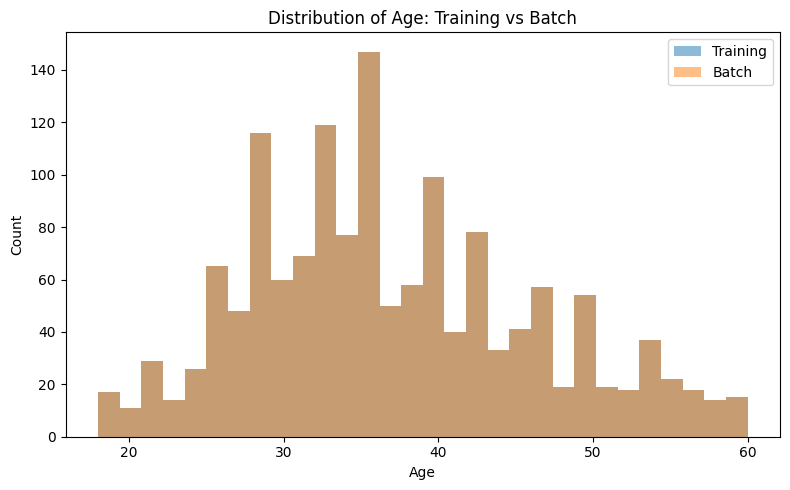

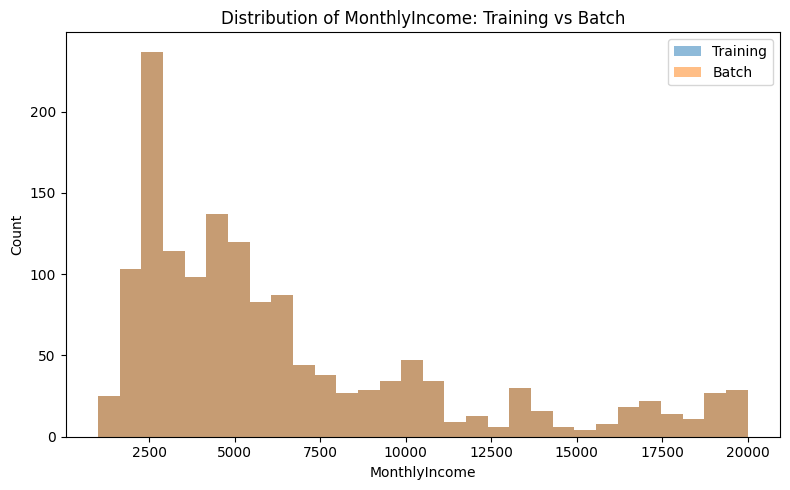

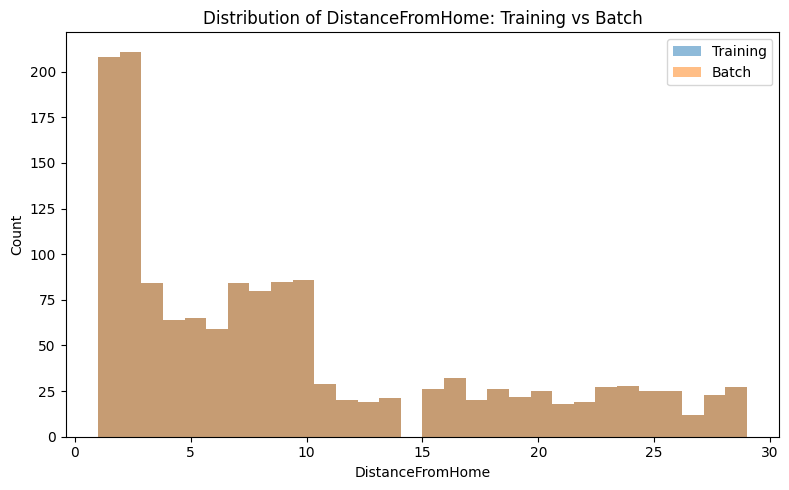

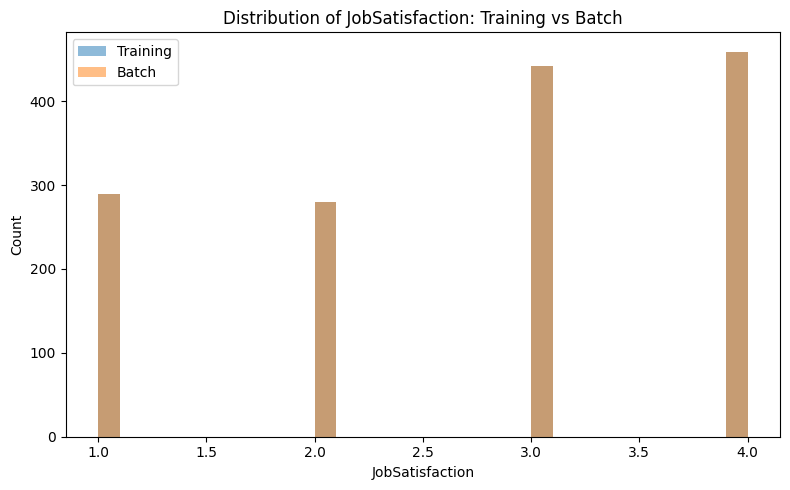

In [8]:
for col in features:
    plt.figure()
    plt.hist(train_df[col], bins=30, alpha=0.5, label="Training")
    plt.hist(merged_df[col], bins=30, alpha=0.5, label="Batch")
    plt.title(f"Distribution of {col}: Training vs Batch")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


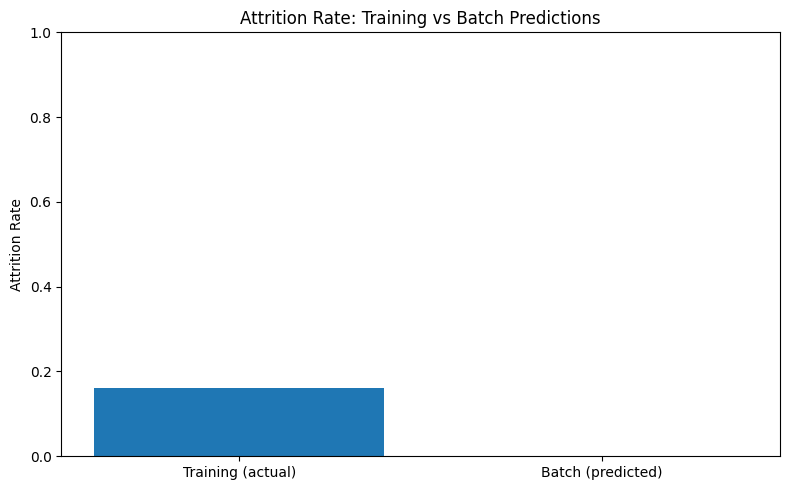

In [9]:
plt.figure()
plt.bar(["Training (actual)","Batch (predicted)"], [train_attrition_rate, batch_pred_rate])
plt.ylabel("Attrition Rate")
plt.title("Attrition Rate: Training vs Batch Predictions")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [10]:
report_path = "../reports/drift_summary.html"

with open(report_path, "w") as f:
    f.write(f"<h1>Drift Summary Report</h1>\n")
    f.write(f"<p>Generated at: {datetime.now()}</p>\n")

    f.write("<h2>Feature Drift Metrics</h2>\n")
    f.write(drift_summary.to_html(index=False))

    f.write("<h2>Attrition / Prediction Rate Comparison</h2>\n")
    f.write(f"<p>Training attrition rate (actual): {train_attrition_rate:.4f}</p>\n")
    f.write(f"<p>Batch predicted attrition rate: {batch_pred_rate:.4f}</p>\n")

print("Saved drift report to:", report_path)


Saved drift report to: ../reports/drift_summary.html
